In [4]:
import torch

lst = [torch.ones(1) for _ in range(5)]
[itm is lst[1] for itm in lst]

[False, True, False, False, False]

In [5]:
[True, True, True].index(False)

ValueError: False is not in list

In [7]:
import numpy as np
np.prod(torch.ones((1,2,3)).shape)

6

In [8]:
a,b,c,d = next(zip(range(5), range(5), range(5), range(5)))

In [12]:
import torch
a = [torch.ones(1) for _ in range(5)]
b = [torch.ones(1) for _ in range(5)]
for a_, b_ in zip(a,b):
    a_+=1
    b_+=1
print(a,b)

[tensor([2.]), tensor([2.]), tensor([2.]), tensor([2.]), tensor([2.])] [tensor([2.]), tensor([2.]), tensor([2.]), tensor([2.]), tensor([2.])]


In [15]:
torch.max(a[0])

tensor(2.)

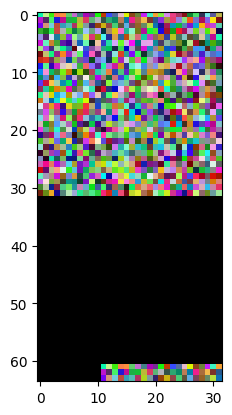

In [13]:
import torch
import matplotlib.pyplot as plt

def crop_fn(x, batch=True):
        from numpy.random import randint
        from torch import from_numpy, meshgrid, clamp, arange
        from torch.nn.functional import pad
        from torch import long as torchlong
        # The image is padded on its surrounding and then cropped.
        ratio = 0.9

        shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
        if batch:
            translation_x = randint(-shift_x, shift_x + 1)
            translation_y = randint(-shift_y, shift_y + 1)
        else:
            translation_x = from_numpy(randint(-shift_x, shift_x+1, (x.size(0), 1, 1))).to(x.device)
            # translation_x = torch.randint(-shift_x,
            #                               shift_x + 1,
            #                               size=[x.size(0), 1, 1],
            #                               device=x.device)

            translation_y = from_numpy(randint(-shift_y, shift_y+1, (x.size(0), 1, 1))).to(x.device)
            # translation_y = torch.randint(-shift_y,
            #                               shift_y + 1,
            #                               size=[x.size(0), 1, 1],
            #                               device=x.device)

        grid_batch, grid_x, grid_y = meshgrid(
            arange(x.size(0), dtype=torchlong, device=x.device),
            arange(x.size(2), dtype=torchlong, device=x.device),
            arange(x.size(3), dtype=torchlong, device=x.device),
        )
        grid_x = clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
        grid_y = clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
        x_pad = pad(x, (1, 1, 1, 1))
        x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
        return x

test_img = torch.rand((1,3,32,32))
test_crop = crop_fn(test_img)
show_tsr = torch.cat([test_img, test_crop], dim=2)
plt.imshow(show_tsr.squeeze(0).permute(1,2,0).numpy())


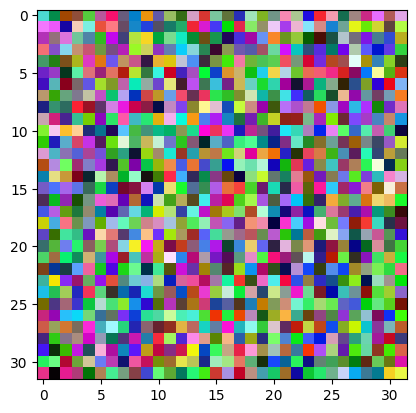

In [19]:
from torchvision.transforms.functional import crop

test_img = torch.rand((2,3,32,32))
plt.imshow(test_img[0].squeeze(0).permute(1,2,0).numpy())



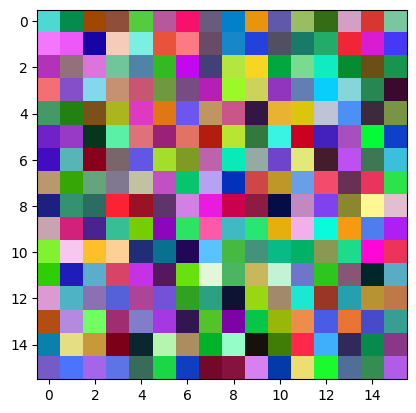

In [20]:
plt.imshow(crop(test_img, 0, 0, 16, 16)[0].squeeze(0).permute(1,2,0).numpy())

In [35]:
def cand_steps(min_steps, num_forward, num_backward, num_interval):
    from numpy import arange
    from numpy.random import randint
    min_steps = max(min_steps, num_forward-num_backward)
    max_steps = num_forward
    full_interval = max_steps-min_steps
    if full_interval<num_interval:
        raise AssertionError("meta loss can be computed in interval {} to {}, this interval is shorter than {}!".format(min_steps, max_steps, num_interval))
    interval = full_interval//num_interval
    if full_interval%num_interval==0:
        candi_itvs = arange(min_steps, max_steps, interval)
    else:
        candi_itvs = arange(min_steps, min_steps+interval*num_interval, interval)
        candi_itvs[-1] = max_steps-interval
    print('candi_itvs: ', candi_itvs)
    candi_itvs += randint(0, interval, num_interval)
    candi_itvs = list(candi_itvs)
    return candi_itvs

cand_steps(1,200,200,5)


candi_itvs:  [  1  40  79 118 161]


[34, 71, 105, 147, 184]

In [24]:
for _ in range(10):
    print(cand_steps(60,200,200,5))

[ 65  98 126 165 200]
[ 78 106 126 166 200]
[ 82 110 129 150 200]
[ 72  88 127 149 200]
[ 69  94 133 163 200]
[ 61 105 132 152 200]
[ 62 109 128 166 200]
[ 85 114 130 168 200]
[ 61  88 143 150 200]
[ 65 109 122 168 200]


In [27]:
cand_steps(60,200,200,0)

ZeroDivisionError: integer division or modulo by zero

In [5]:
from models.convnet import convnet3
from torch.optim import Adam

model = convnet3().to('cuda')
cuda_lst = list(model.parameters())
print('cuda: ', cuda_lst[0].device)
model.to('cpu')
cpu_lst = list(model.parameters())
print('cuda: ', cuda_lst[0].device)
print('cpu: ', cpu_lst[0].device)

cuda:  cuda:0
cuda:  cpu
cpu:  cpu


In [3]:
tsr = torch.ones(1)
tsr.backward

torch.nn.parameter.Parameter

device(type='cpu')

In [11]:
import torch
from time import time
a = [torch.ones(5,5).to('cuda') for _ in range(100)]
b = torch.cat([ele.flatten() for ele in a])
tm = time()

tm = time()
for _ in range(10000):
    for ele in a:
        ele.add_(1.)
tm = time()-tm
print('list tensor took {}'.format(tm))

tm = time()
for _ in range(10000):
    a_lst = [b[25*idx:(idx+1)*25].view((5,5)) for idx in range(100)]
    b.add_(1.)
tm = time()-tm
print('flat tensor took {}'.format(tm))



list tensor took 7.333452224731445
flat tensor took 5.742737293243408


In [4]:
import torch
import torch.jit

@torch.jit.script
def inplace_add(a,b):
    a.add_(b)
    return None

a = torch.ones(1)
inplace_add(a, torch.ones(1)*10)

In [5]:
a

tensor([11.])

In [10]:
from typing import Tuple, List
from torch import Tensor

@torch.jit.script
def flatten(tsrs:List[Tensor]):
    return torch.cat([tsr.flatten() for tsr in tsrs])

def flatten_(tsrs:List[Tensor]):
    return torch.cat([tsr.flatten() for tsr in tsrs])

flatten([torch.ones((2,2)) for _ in range(3)])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
@torch.jit.script
def flatten_detached(tsrs:List[Tensor]):
    return torch.cat([tsr.detach().flatten() for tsr in tsrs])

flatten_detached([torch.ones((2,2)) for _ in range(3)])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])